In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, CategoryParameter, expand_plist, FieldSelector, Parameter, wwr
from besos.problem import EPProblem
plt.rcParams['figure.figsize'] = [8, 8]

In [14]:
filename = 'model_final_triple'
#building = ef.get_building('/home/ict4bd/'+filename+'.idf')
building = ef.get_building('/home/brendan/Desktop/polito/ICTBuilding/labBuilding/'+filename+'.idf')

In [15]:
[materials.Name for materials in building.idfobjects["MATERIAL"]] # get a list of the Name property of all IDF objects of class MATERIAL

['Cast Concrete (Dense)_.1',
 'Asphalt 1_.O1',
 'MW Glass Wool (rolls)_.1445',
 'Plasterboard_.O13',
 'Gypsum Plasterboard_.O25',
 'Cement/plaster/mortar - cement_.O3',
 'XPS Extruded Polystyrene  - CO2 Blowing_.2',
 'Aerated Concrete Block_.2']

In [16]:
building.idfobjects["BUILDING"][0]


Building,
    Building,                 !- Name
    0,                        !- North Axis
    Suburbs,                  !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

In [17]:
insulation = FieldSelector(class_name='Material',\
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.2',\
                           field_name='Thickness')
ach_bedroom = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Bedroom Nat Vent', field_name='Air Changes per Hour')
ach_bathroom=FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Bathroom Nat Vent', field_name='Air Changes per Hour')
ach_kitchen=FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Kitchen Nat Vent', field_name='Air Changes per Hour')
shading_bedroom = FieldSelector(class_name='WindowShadingControl',object_name='1001-Block1:Bedroom', field_name='Setpoint')
shading_bathroom = FieldSelector(class_name='WindowShadingControl',object_name='1002-Block1:Bathroom', field_name='Setpoint')
shading_kitchen = FieldSelector(class_name='WindowShadingControl',object_name='1003-Block1:Kitchen', field_name='Setpoint')
orientation = FieldSelector(class_name='Building',object_name='Building',field_name='North Axis')

In [18]:
zero_to_one_exclusive = CategoryParameter(options=[0.00001, 0.10, 0.20])
ach_parameters = CategoryParameter(options=[0,5])
shading_parameters = CategoryParameter(options=[120,2000])
orientation_parameters = CategoryParameter(options=[0.0, 90.0, 180.0, 270.0])

In [19]:
insulation_param = Parameter(selector=insulation,
                                 value_descriptor=zero_to_one_exclusive,
                                 name='Insulation Thickness')

ach_bedroom_param = Parameter(selector=ach_bedroom,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Bedroom')

ach_bathroom_param = Parameter(selector=ach_bathroom,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Bathroom')

ach_kitchen_param = Parameter(selector=ach_kitchen,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Kitchen')

shading_bedroom_param=Parameter(selector=shading_bedroom,
                                 value_descriptor=shading_parameters,
                                 name='Shading Bedroom')

shading_bathroom_param=Parameter(selector=shading_bathroom,
                                 value_descriptor=shading_parameters,
                                 name='Shading Bathroom')

shading_kitchen_param=Parameter(selector=shading_kitchen,
                                 value_descriptor=shading_parameters,
                                 name='Shading Kitchen')

orientation_param = Parameter(selector = orientation, 
                              value_descriptor = orientation_parameters, 
                              name = 'Orientation')


In [20]:
window_to_wall = wwr(RangeParameter(0.1,0.9)) # use a special shortcut to get the window-to-wall parameter
window_to_wall

Parameter(name='Window to Wall Ratio', selector=wwrSelector(), value_descriptor=RangeParameter(min=0.1, max=0.9))

In [21]:
# Add all the parameters to a single parameters object.
#parameters = [insulation_param] + [window_to_wall]
parameters = [window_to_wall,insulation_param,orientation_param,ach_bedroom_param,ach_bathroom_param,ach_kitchen_param,shading_bedroom_param,shading_bathroom_param,shading_kitchen_param] 

# Let us try to optimize the Cooling and the Heating of facility at the same time
objectives = ['Electricity:Facility','DistrictCooling:Facility'] 
#'InteriorLights:Electricity' has correlation circa 1 with ELectricity:Facility, we remove it from the obj
# These are hourly values, default is sum all the hourly values

# Construct the problem 
problem = EPProblem(parameters, objectives) # Make a problem instance from the parameters and objectives

In [22]:
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=20)

#samples = pd.read_csv(filename+'.csv').drop(['Electricity:Facility','DistrictCooling:Facility'], axis=1)
samples

,Window to Wall Ratio,Insulation Thickness,Orientation,Air Changes per Hour Bedroom,Air Changes per Hour Bathroom,Air Changes per Hour Kitchen,Shading Bedroom,Shading Bathroom,Shading Kitchen
0,0.612134,0.10000,180.0,5,0,5,120,120,2000
1,0.850715,0.20000,0.0,5,5,0,120,120,2000
2,0.516207,0.10000,180.0,0,0,5,2000,2000,120
3,0.895974,0.10000,180.0,0,0,0,120,2000,2000
4,0.401828,0.20000,90.0,0,5,0,120,2000,2000
5,0.195847,0.10000,0.0,0,0,0,120,120,2000
6,0.159906,0.20000,270.0,0,5,0,120,120,120
7,0.755150,0.20000,90.0,0,0,0,2000,2000,120
8,0.665654,0.00001,180.0,5,5,5,120,2000,120
9,0.450681,0.00001,90.0,5,5,0,2000,120,120


In [23]:
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw='../larnaca.epw')
outputs = evaluator.df_apply(samples, keep_input=True)
outputs.describe()

,Window to Wall Ratio,Insulation Thickness,Orientation,Air Changes per Hour Bedroom,Air Changes per Hour Bathroom,Air Changes per Hour Kitchen,Shading Bedroom,Shading Bathroom,Shading Kitchen,Electricity:Facility,DistrictCooling:Facility
count,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01
mean,0.500814,0.105003,135.00000,2.500000,2.500000,2.500000,1060.000000,1060.000000,1060.000000,3.738246e+09,9.080318e+09
std,0.237411,0.082554,103.23708,2.564946,2.564946,2.564946,964.419651,964.419651,964.419651,1.672472e+08,1.300906e+09
min,0.117294,0.000010,0.00000,0.000000,0.000000,0.000000,120.000000,120.000000,120.000000,3.500518e+09,7.058312e+09
25%,0.322660,0.000010,67.50000,0.000000,0.000000,0.000000,120.000000,120.000000,120.000000,3.612024e+09,7.836443e+09
50%,0.499735,0.100000,135.00000,2.500000,2.500000,2.500000,1060.000000,1060.000000,1060.000000,3.732758e+09,9.125619e+09
75%,0.678621,0.200000,202.50000,5.000000,5.000000,5.000000,2000.000000,2000.000000,2000.000000,3.830583e+09,1.008930e+10
max,0.895974,0.200000,270.00000,5.000000,5.000000,5.000000,2000.000000,2000.000000,2000.000000,4.085876e+09,1.104234e+10


Text(0, 0.5, 'DistrictCooling:Facility')

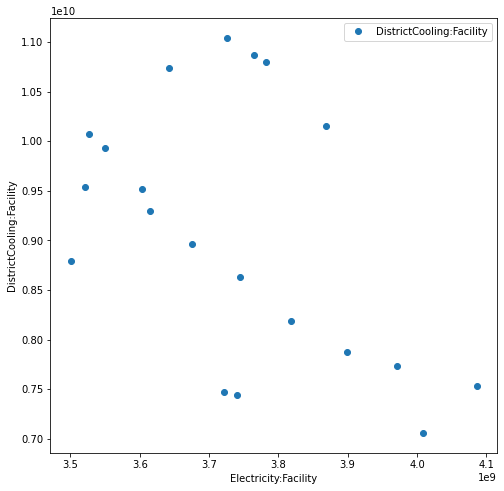

In [24]:
_ = outputs.plot(x=objectives[0], y=objectives[1], style = 'o')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])

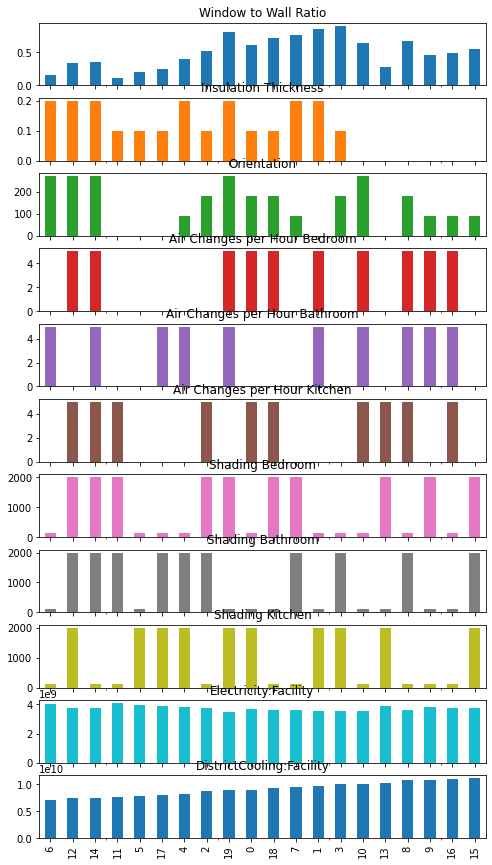

In [25]:
outputs = outputs.sort_values(by=objectives[1])
ax=outputs.plot.bar(subplots=True,legend=None, figsize=(8,15))
outputs.to_csv(filename + '_orientation' + '.csv', index = False)

In [26]:
outputs

,Window to Wall Ratio,Insulation Thickness,Orientation,Air Changes per Hour Bedroom,Air Changes per Hour Bathroom,Air Changes per Hour Kitchen,Shading Bedroom,Shading Bathroom,Shading Kitchen,Electricity:Facility,DistrictCooling:Facility
6,0.159906,0.20000,270.0,0,5,0,120,120,120,4.009231e+09,7.058312e+09
12,0.338865,0.20000,270.0,5,0,5,2000,2000,2000,3.739996e+09,7.436804e+09
14,0.351396,0.20000,270.0,5,5,5,2000,2000,120,3.721658e+09,7.470101e+09
11,0.117294,0.10000,0.0,0,0,5,2000,2000,120,4.085876e+09,7.535966e+09
5,0.195847,0.10000,0.0,0,0,0,120,120,2000,3.971539e+09,7.732892e+09
17,0.249952,0.10000,0.0,0,5,0,120,2000,2000,3.898806e+09,7.870960e+09
4,0.401828,0.20000,90.0,0,5,0,120,2000,2000,3.817966e+09,8.185021e+09
2,0.516207,0.10000,180.0,0,0,5,2000,2000,120,3.744400e+09,8.629090e+09
19,0.797382,0.20000,270.0,5,5,0,2000,120,2000,3.500518e+09,8.793511e+09
0,0.612134,0.10000,180.0,5,0,5,120,120,2000,3.675017e+09,8.958856e+09


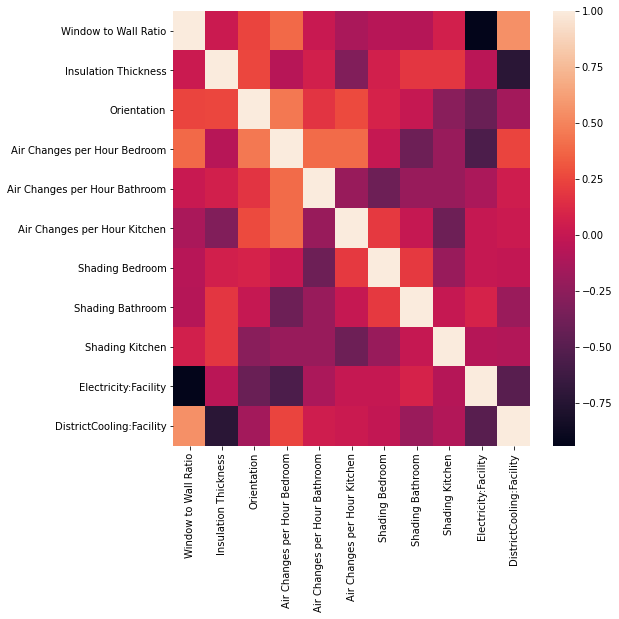

In [30]:
gigi= heatmap(outputs.corr())
plt.savefig('heatmap_sam.png')